<a href="https://colab.research.google.com/github/soumilbaldota/MahindraMRV/blob/main/Car_Review_Sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import warnings
warnings.filterwarnings('ignore')
warnings.warn("this will not show")

#Importing Datasets


In [3]:
#downloading/importing dataset from google drive
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


#Prerequisites for VADER

In [4]:
#install and import nltk
!pip install nltk
import nltk
#download the lexicon
nltk.download("vader_lexicon")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [5]:
!pip install kaleido
import kaleido #required
kaleido.__version__ #0.2.1

import plotly
plotly.__version__ #5.5.0

#now this works:
import plotly.graph_objects as go

import plotly.io as pio

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


#Importing Required Libraries


In [6]:
import numpy as np
import pandas as pd
import re
from textblob import TextBlob
from wordcloud import WordCloud
import seaborn as sns
import matplotlib.pyplot as plt
import cufflinks as cf
%matplotlib inline
import plotly.graph_objs as go
from plotly.subplots import make_subplots
import plotly.io as pio


pd.set_option('display.max_columns', None)

In [7]:
df = pd.read_csv("/content/drive/MyDrive/Mahindra_Thar.csv")

In [8]:
df.head()

,overall,reviews
0,0,NaN
1,1,Please don't buy this car it's one the most un...
2,1,If it's an off road vehicle or cruze vehicle b...
3,2,NaN
4,3,Mahindra Thar has following benefits over the ...


In [9]:
df

,overall,reviews
0,0,NaN
1,1,Please don't buy this car it's one the most un...
2,1,If it's an off road vehicle or cruze vehicle b...
3,2,NaN
4,3,Mahindra Thar has following benefits over the ...
...,...,...
129,5,i had driven the all-new Thar for about couple...
130,5,"Superb Thar muscular look like an elephant, to..."
131,5,Perfect Bull... A car where you can trust on i...
132,5,Rough n tough Quality 4x4 drive with loaded dr...


In [10]:
def missing_values_analysis(df):
  na_columns_ = [col for col in df.columns if df[col].isnull().sum() > 0]
  n_miss = df[na_columns_].isnull().sum().sort_values(ascending = True)
  ratio_ = (df[na_columns_].isnull().sum() / df.shape[0] * 100).sort_values(ascending = True)
  missing_df = pd.concat([n_miss, np.round(ratio_, 2)], axis = 1, keys = ['Missing Values', 'Ratio'])
  missing_df = pd.DataFrame(missing_df)
  
  return missing_df

def check_dataframe(df, head = 5, tail = 5):
  print("SHAPE".center(82, '~'))
  print('Rows: {}'.format(df.shape[0]))
  print('Columns: {}'.format(df.shape[1]))
  print("TYPES".center(82, '~'))
  print(df.dtypes)
  print("".center(82, '~'))
  print(missing_values_analysis(df))
  print("DUPLICATED VALUES".center(83, '~'))
  print(df.duplicated().sum())
  print("QUANTILES".center(82, '~'))
  print(df.quantile([0, 0.05, 0.50, 0.95, 0.99, 1]).T)

check_dataframe(df)

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~SHAPE~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Rows: 134
Columns: 2
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~TYPES~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
overall     int64
reviews    object
dtype: object
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
         Missing Values  Ratio
reviews               2   1.49
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~DUPLICATED VALUES~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
0
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~QUANTILES~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
         0.00  0.05  0.50  0.95  0.99  1.00
overall   0.0   3.0   5.0   5.0   5.0   5.0


In [11]:
def check_class(dataframe):
  nunique_df = pd.DataFrame({'Variable': dataframe.columns,
                             'Classes': [dataframe[i].nunique() \
                                         for i in dataframe.columns]})
  nunique_df = nunique_df.sort_values('Classes', ascending = False)
  nunique_df = nunique_df.reset_index(drop = True)
  
  return nunique_df

check_class(df)

,Variable,Classes
0,reviews,132
1,overall,6


In [12]:
constraints = ['#B34D22', '#EBE00C', '#1FEB0C', '#0C92EB', '#EB0CD5']
def categorical_variable_summary(df, column_name):
  fig = make_subplots(rows = 1, cols = 2, 
                      subplot_titles = ('Countplot', 'Percentage'),
                      specs = [[{"type" : "xy"}, {'type' : 'domain'}]])
  
  fig.add_trace(go.Bar(y = df[column_name].value_counts().values.tolist(),
                       x = [str(i) for i in df[column_name].value_counts().index],
                       text = df[column_name].value_counts().values.tolist(),
                       textfont = dict(size = 14),
                       name = column_name,
                       textposition = 'auto',
                       showlegend = False,
                       marker = dict(color = constraints,
                                     line = dict(color = '#DBE6EC',
                                                 width = 1))),
                row = 1, col = 1)
  
  fig.add_trace(go.Pie(labels = df[column_name].value_counts().keys(),
                       values = df[column_name].value_counts().values,
                       textfont = dict(size = 18),
                       textposition = 'auto',
                       showlegend = False,
                       name = column_name,
                       marker = dict(colors = constraints)),
                row = 1, col = 2)
  
  fig.update_layout(title = {'text' : column_name, 'y' : 0.9, 'x' : 0.5,
                             'xanchor' : 'center', 'yanchor' : 'top'},
                    template = 'plotly_white')
  
  # fig.show()
  return fig


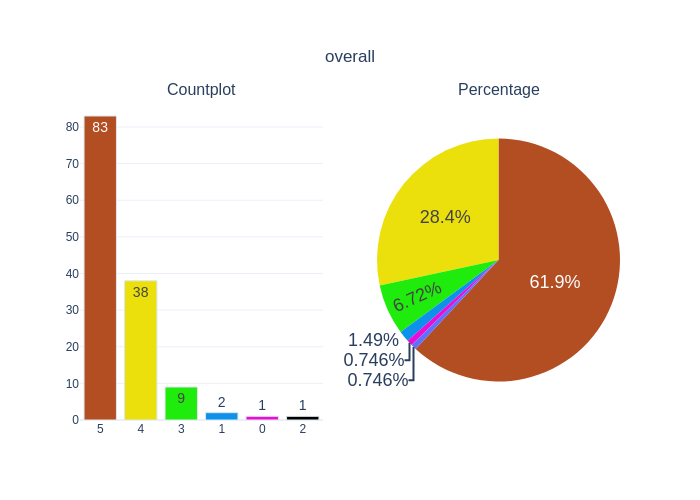

In [13]:
#not showing the output here
fig = categorical_variable_summary(df, 'overall')
img = fig.to_image(format = 'png', engine = 'kaleido' )
from IPython.display import Image
Image(img)

#Sentiment Analysis of data


Exploring the Reviews

In [14]:
df.reviews.head()


0                                                  NaN
1    Please don't buy this car it's one the most un...
2    If it's an off road vehicle or cruze vehicle b...
3                                                  NaN
4    Mahindra Thar has following benefits over the ...
Name: reviews, dtype: object

In [15]:
review_example = df.reviews[100]
review_example

'Very nice drive for off road . We can pull the trolley easily due to four wheel drive it easily overcomes the straps and power of engine is wonderful and bonnet of car is easily viewed by driver'

Cleaning the Data using REGEX (Regular Expressions)

In [16]:
review_example = re.sub("[^a-zA-Z]", '', review_example)
review_example


'VerynicedriveforoffroadWecanpullthetrolleyeasilyduetofourwheeldriveiteasilyovercomesthestrapsandpowerofengineiswonderfulandbonnetofcariseasilyviewedbydriver'

Converting capital letter words into lower case

In [17]:
review_example = review_example.lower().split()


In [18]:
review_example

['verynicedriveforoffroadwecanpullthetrolleyeasilyduetofourwheeldriveiteasilyovercomesthestrapsandpowerofengineiswonderfulandbonnetofcariseasilyviewedbydriver']

In [19]:
rt = lambda x : re.sub("[^a-zA-Z]", ' ', str(x))
df["reviews"] = df["reviews"].map(rt)
df["reviews"] = df["reviews"].str.lower()
df.head()


,overall,reviews
0,0,nan
1,1,please don t buy this car it s one the most un...
2,1,if it s an off road vehicle or cruze vehicle b...
3,2,nan
4,3,mahindra thar has following benefits over the ...


Performing Sentiment Analysis

In [20]:
#importing the lexicon
from nltk.sentiment.vader import SentimentIntensityAnalyzer

#creating an instance of SentimentIntensityAnalyzer
sent_analyzer = SentimentIntensityAnalyzer()

df[['polarity', 'subjectivity']] = df['reviews'].apply(lambda Text:pd.Series(TextBlob(Text).sentiment))
#polarity sends the mood and ranges between 0 and 1 - more towards 1, it is positive and towards 0, it is negative

for index, row in df['reviews'].iteritems():
  score = sent_analyzer.polarity_scores(row)

  neg = score['neg']
  neu = score['neu']
  pos = score['pos']

  if neg > pos:
    df.loc[index, 'sentiment'] = "Negative"
  elif pos > neg:
    df.loc[index, 'sentiment'] = "Positive"
  else:
    df.loc[index, 'sentiment'] = "Neutral"


In [21]:
df[df['sentiment'] == 'Positive'].head(5)

,overall,reviews,polarity,subjectivity,sentiment
1,1,please don t buy this car it s one the most un...,0.102593,0.418519,Positive
2,1,if it s an off road vehicle or cruze vehicle b...,0.325000,0.725000,Positive
4,3,mahindra thar has following benefits over the ...,0.133333,0.461111,Positive
5,3,very good and nice car runs very smoothly in ...,0.406000,0.726000,Positive
6,3,mahindra thar is capable of becoming ...,0.235714,0.387500,Positive


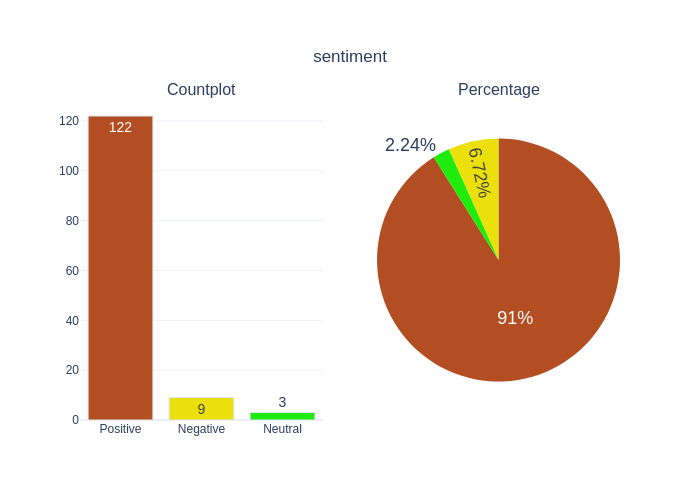

In [22]:
fig = categorical_variable_summary(df, 'sentiment')
img = fig.to_image(format = 'png', engine = 'kaleido' )
from IPython.display import Image
Image(img)